In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers, callbacks
from sklearn.datasets import fetch_openml 
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

import tensorflow.keras.backend as K

# Importing and Splitting Data

In [3]:
data = fetch_openml('Kuzushiji-MNIST')

In [4]:
X, t = data.data.to_numpy(), data.target.to_numpy()
X = X/255. # accomplishes the scaling
X = X.reshape((70000,28,28))
t = t.astype(np.uint8)

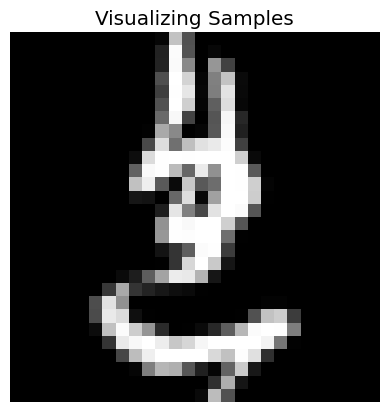

In [5]:
plt.imshow(X[34566], cmap='gray')
plt.axis('off')
plt.title('Visualizing Samples');

In [6]:
X_train, X_test, t_train, t_test = X[:60000], X[60000:], t[:60000], t[60000:]
X_train, X_val, t_train, t_val = train_test_split(X_train, t_train, 
                                                  test_size = 0.20,
                                                  stratify = t_train,
                                                  random_state = 0)

# Classification Performance as a Function of Bottleneck Size

313/313 [==============================] - 0s 1ms/step - loss: 0.3158 - accuracy: 0.9160


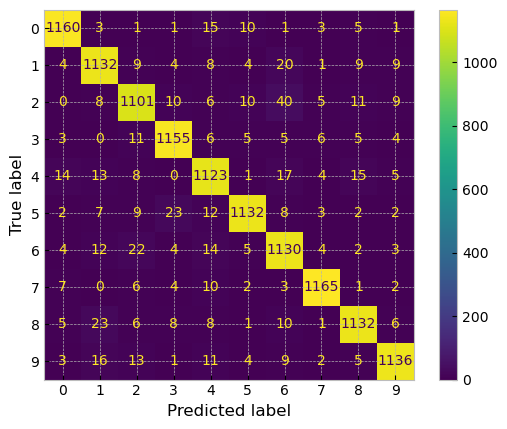

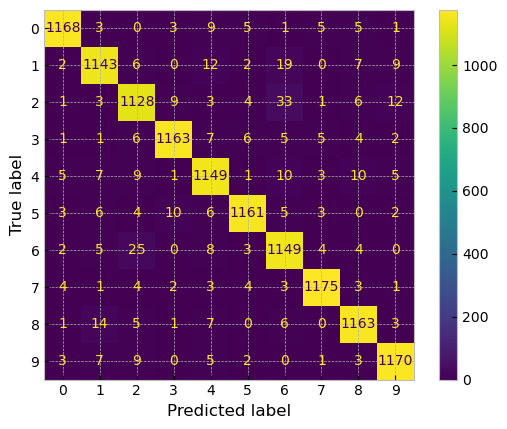

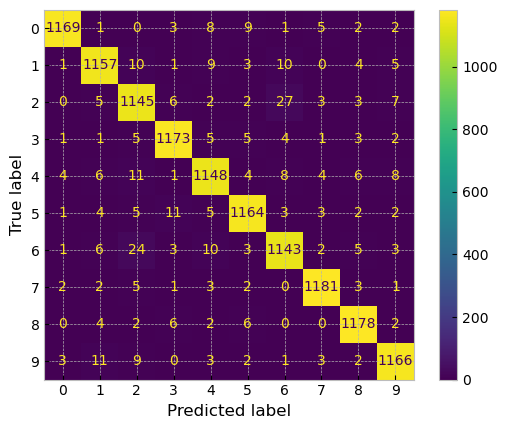

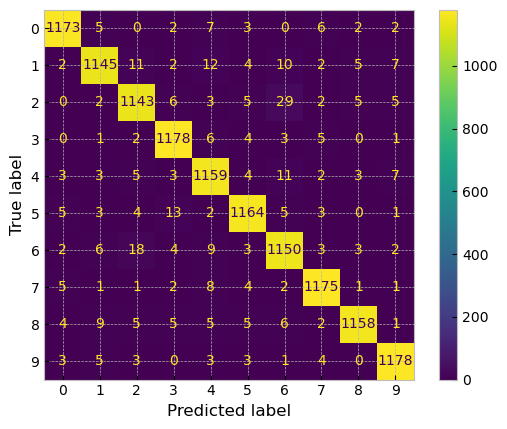

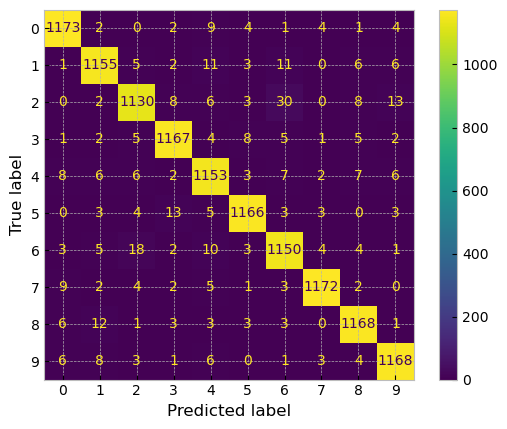

In [15]:
bottleneck = [10, 50, 100, 200, 300]

callback = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
optimizer = optimizers.Adam(learning_rate=0.0005,
                        beta_1=0.875,
                        beta_2=0.997)

y_pred = np.zeros((len(bottleneck), t_val.shape[0]))
performance_val = np.zeros((len(bottleneck), 2))
performance_test = np.zeros((len(bottleneck), 2))

for idx, bottleneckNum in np.ndenumerate(bottleneck):
    encoder = models.Sequential([
                layers.Flatten(input_shape=[28,28]),
                layers.Dense(800,  activation='relu', use_bias=False),
                layers.Dense(200,  activation='relu', use_bias=False),
                layers.Dense(bottleneckNum,  activation='relu', use_bias=False)
            ])

    decoder = models.Sequential([
        layers.Dense(200,  activation='relu', use_bias=False),
        layers.Dense(800,  activation='relu', use_bias=False),
        layers.Dense(28*28, use_bias=False),
        layers.Reshape([28, 28])
    ])

    autoencoder = models.Sequential([encoder, decoder])

    autoencoder.compile(loss=losses.MeanSquaredError(reduction="sum_over_batch_size"), 
                        optimizer=optimizer)

    historySAE = autoencoder.fit(X_train, X_train, epochs=200, 
                validation_data=(X_val, X_val),
                callbacks=callback,
                verbose=0)
    
    codings_train = encoder.predict(X_train)
    codings_val = encoder.predict(X_val)
    codings_test = encoder.predict(X_test)
    
    classifier = models.Sequential([
        layers.Input(shape=(bottleneckNum,)),
        layers.Dense(4096, activation = 'relu'),
        layers.Dense(10, activation = 'softmax')
    ])

    classifier.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = optimizer,
             metrics = ['accuracy'])

    history = classifier.fit(codings_train, t_train, epochs = 500,
                        batch_size = 1024,
                        validation_data = (codings_val, t_val),
                        callbacks = [callback],
                        verbose=0)
    
    y_proba = classifier.predict(codings_val)
    y_pred[idx,:] = np.argmax(y_proba, axis=1)
    
    y_pred_for_eval = y_pred[idx, :]  # Ensure this is the correct set of predictions
    y_pred_for_eval = y_pred_for_eval.flatten() 
    
    performance_val[idx,:] = classifier.evaluate(codings_val, t_val)
    performance_test[idx,:] = classifier.evaluate(codings_test, t_test)
    
    filename = 'CM_Bneck' + str(bottleneckNum) + '.png'
    conf_mx = confusion_matrix(t_val, y_pred_for_eval)
    disp_cm = ConfusionMatrixDisplay(conf_mx, display_labels = range(10))
    disp_cm.plot()
    plt.savefig(filename);

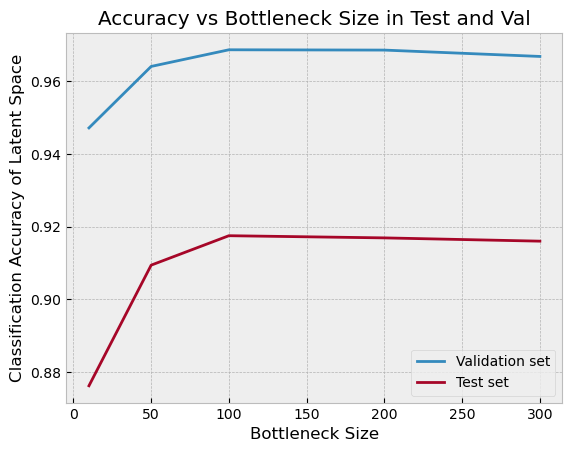

In [20]:
plt.figure()

plt.plot(bottleneck, performance_val[:,1], label='Validation set')
plt.plot(bottleneck, performance_test[:,1], label='Test set')
plt.title('Accuracy vs Bottleneck Size in Test and Val')
plt.xlabel('Bottleneck Size')
plt.ylabel('Classification Accuracy of Latent Space')
plt.legend()

### Loading Trained Model

In [38]:
bottleneck = 200

encoder = models.Sequential([
            layers.Flatten(input_shape=[28,28]),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(bottleneck,  activation='relu', use_bias=False)
        ])

decoder = models.Sequential([
    layers.Dense(200,  activation='relu', use_bias=False),
    layers.Dense(800,  activation='relu', use_bias=False),
    layers.Dense(28*28, use_bias=False),
    layers.Reshape([28, 28])
])

autoencoder = models.Sequential([encoder, decoder])

In [39]:
autoencoder.load_weights('SAE_weights.h5')
encoder = autoencoder.layers[0]
decoder = autoencoder.layers[1]

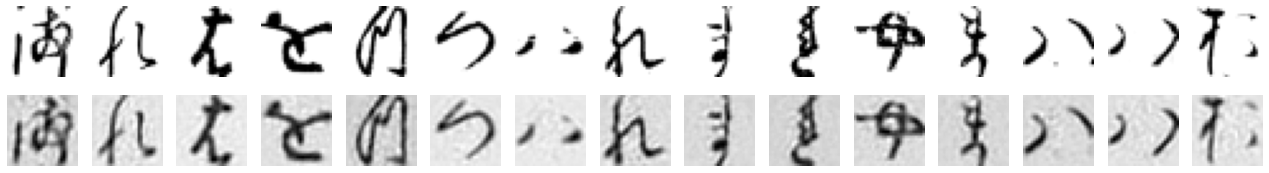

In [40]:
# visualize images reconstructed from encodings
def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')

def show_reconstructions(model, n_images=15):
    reconstructions = model.predict(X_val[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X_val[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(autoencoder)

The reconstructions look really good!!

# Custom Loss Function
There are many possible loss functions for classification. However, for this project we have been given the template of using a distance formulation as such: $ R = 1/K\sum_{i=1}^{K} d_i $. We can make modifications to the lambda value that we multiply by R, the distance metric, the batch size K, and other implementation criteria. We will try euclidean distance (with latent space normalization), as well as a Manhattan block distance, and Chebyshev distances.

In [65]:
# custom SAE loss
from sklearn.preprocessing import StandardScaler

class StackedAutoencoderLoss:
    # (tf.keras.losses.Loss)
    def __init__(self, lam=0.5, name="stacked_autoencoder_loss", distance_type = 'l2', prior_dir='sparse'):
        """
        Initialize the loss class.

        Args:
            lam (float): Weighting factor for the custom latent space loss component.
            name (str): Name of the loss.
            distance_type (str): one of 'l1', 'l2', or 'linf' describing the three distance types
            prior_dir (str): either 'sparse' for a sparse encoding or 'dense' for a Gram Schmidt dense matrix
        """
        # super().__init__(name=name)
        self.lam = lam
        self.distance_type = distance_type
        self.prior_dir = prior_dir
        

    def __call__(self, y_true, y_pred, latent_space=None, prior=None):
        if prior is None:
            raise ValueError("Prior argument is required.")
        
        if latent_space is None:
            raise ValueError("Latent space argument is required.")
        """
        Compute the combined loss.

        Args:
            y_true (Tensor): Tensor of true input values for reconstruction (e.g., autoencoder input).
            y_pred (Tensor): Tensor of reconstructed values (autoencoder output).
            latent_space (Tensor): Tensor representing the latent space embeddings.
            prior (Int): Integer of the for the input's class.
         

        Returns:
            A scalar Tensor representing the combined loss value.
        """
        # print(f"y_true shape: {y_true.shape}")
        # print(f"y_pred shape: {y_pred.shape}")
        # print(f"latent_space shape: {latent_space.shape}")
        # print(f"prior shape: {prior.shape}")
        
        # Get batch size
        batch_size = tf.shape(y_true)[0]
        
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Get latent_space and prior length
        latent_dim = latent_space.shape[-1]
        num_classes = 10
        
        # Reconstruction loss (MSE) across all elements in the batch
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred), axis=(1, 2))  # Adjust axes for your data shape

        # Make prior direction
        if self.prior_dir == 'sparse':
            prior_directions = self.generate_orthogonal_directions(num_classes, latent_dim)
            
        elif self.prior_dir == 'dense':
            prior_directions = self.generate_dense_orthogonal_directions(num_classes, latent_dim)
            
        else:
            raise ValueError("Prior direction may only be 'dense' or 'sparse'.")
        
        # Get the distance measure
        # selected_prior_direction = prior_directions[prior, :]
        prior_casted = tf.cast(prior, tf.int32)
        selected_prior_direction = tf.gather(prior_directions, prior_casted, axis=0)
        
        latent_space_casted = tf.cast(latent_space, tf.float32)
        selected_prior_direction_casted = tf.cast(selected_prior_direction, tf.float32)

        # Compute latent space distance based on the specified metric
        if self.distance_type == 'l1':
            # L1 distance: Sum of absolute differences
            latent_loss = tf.reduce_mean(tf.abs(latent_space_casted - selected_prior_direction_casted), axis=1)
        elif self.distance_type == 'l2':
            # L2 distance: Euclidean distance (squared differences)
            latent_loss = tf.reduce_mean(tf.square(latent_space_casted - selected_prior_direction_casted), axis=1)
        elif self.distance_type == 'linf':
            # Linf distance: Maximum absolute difference
            latent_loss = tf.reduce_max(tf.abs(latent_space_casted - selected_prior_direction_casted), axis=1)
        else:
            raise ValueError("Distance type must be 'l1', 'l2', or 'linf'.")
        

        # Latent space loss (e.g., L2 distance to prior)
        latent_loss = latent_loss / tf.cast(batch_size, tf.float32)
        
        mse_loss = tf.reduce_mean(mse_loss)  # Reduce to a scalar
        latent_loss = tf.reduce_mean(latent_loss) 

        # Combine both losses per sample in the batch
        total_loss = (self.lam * mse_loss) + ((1- self.lam) * latent_loss)

        # Average over the batch
        return tf.reduce_mean(total_loss)
    
    def generate_dense_orthogonal_directions(self, num_classes, latent_dim, seed=10):
        """
        Generate dense orthogonal target directions using Gram-Schmidt process.

        Args:
            num_classes (int): Number of classes.
            latent_dim (int): Dimensionality of the latent space.

        Returns:
            np.ndarray: Array of shape (num_classes, latent_dim) containing dense orthogonal unit vectors.
        """
        if num_classes > latent_dim:
            raise ValueError("Number of classes cannot exceed latent space dimensionality.")

        np.random.seed(seed)
        # Start with random vectors
        random_vectors = np.random.randn(num_classes, latent_dim)

        # Apply Gram-Schmidt process to orthogonalize
        orthogonal_vectors = []
        for v in random_vectors:
            for u in orthogonal_vectors:
                v -= np.dot(v, u) * u  # Subtract projection
            v = v / np.linalg.norm(v)  # Normalize
            orthogonal_vectors.append(v)
        
        return np.array(orthogonal_vectors)
    
    def generate_orthogonal_directions(self, num_classes, latent_dim):
        """
        Generate orthogonal target directions in latent space.

        Args:
            num_classes (int): Number of classes.
            latent_dim (int): Dimensionality of the latent space.

        Returns:
            np.ndarray: Array of shape (num_classes, latent_dim) containing orthogonal unit vectors.
        """
        if num_classes > latent_dim:
            raise ValueError("Number of classes cannot exceed latent space dimensionality.")

        # Start with an identity matrix for orthogonal vectors
        identity_matrix = np.eye(latent_dim)

        # Select the first num_classes rows
        target_directions = identity_matrix[:num_classes]

        return target_directions
    

# Create train and test functions

In [66]:
############################# Training Functions ###########################################

# Custom Training Step
@tf.function
def train_step(x, class_labels, model, loss_fn, optimizer):
    with tf.GradientTape() as tape:
        y_pred, latent_space = model(x)  # Forward pass
        # Check if y_pred or latent_space is a tuple
        class_labels = tf.reshape(class_labels, (-1, 1))
        
        # print(f"x shape: {x.shape}")
        # print(f"class_labels shape: {class_labels.shape}")
        # print(f"y_pred shape: {y_pred.shape}")
        # print(f"latent_space shape: {latent_space.shape}")
        
        # Pass class_labels as prior to the loss function
        loss_value = loss_fn(x, y_pred, latent_space, class_labels)  # Corrected call to loss_fn with 4 arguments
    grads = tape.gradient(loss_value, model.trainable_variables)  # Compute gradients
    optimizer.apply_gradients(zip(grads, model.trainable_variables))  # Apply gradients
    return loss_value



# Training Loop with validation loss tracking
def train(train_dataset, val_dataset, epochs, model, optimizer, loss_fn, verbose=True):
    best_val_loss = float('inf')  # Track the best validation loss
    for epoch in range(epochs):
        if verbose == True:
            print(f"Epoch {epoch+1}/{epochs}")
        
        # Store all the training losses
        avg_trn_loss = np.zeros(epochs)
        # Training phase
        trn_loss = 0
        for x_batch, class_labels in train_dataset:
            loss_value = train_step(x_batch, class_labels, model, loss_fn, optimizer)  # Train step
            trn_loss += loss_value
            # print(f"Training Loss: {loss_value.numpy()}")
        avg_trn_loss[epoch] = trn_loss/len(train_dataset)
        
        
        # Validation phase (compute the validation loss)
        val_loss = 0
        for x_batch_val, class_labels_val in val_dataset:
            y_pred_val, latent_space_val = model(x_batch_val)  # Forward pass
            val_loss += loss_fn(x_batch_val, y_pred_val, latent_space_val, class_labels_val).numpy()
        
        # Calculate average validation loss over the validation dataset
        val_loss /= len(val_dataset)
        
        if verbose==True:
            print(f"Training Loss: {trn_loss/len(train_dataset)}")
            print(f"Validation Loss: {val_loss}")
        
        # Save the best model weights based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            model.set_weights(model.get_weights())  # Save the best model weights
            if verbose == True:
                print("Best model weights saved!")

    print("Training completed!")
    
    return avg_trn_loss, best_val_loss

class CustomAutoencoder(tf.keras.Model):
    def __init__(self, encoder, decoder, loss_fn):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.loss_fn = loss_fn

    def call(self, x):
        latent_space = self.encoder(x)
        y_pred = self.decoder(latent_space)
        return y_pred, latent_space


################################## Testing Functions #################################################
def test_step(x, class_labels, model, classifier):
    y_pred, latent_space = model(x, training=False)  # Forward pass in eval mode
    # loss_value = loss_fn(x, y_pred, latent_space, class_labels)  # Compute loss
    test_loss, test_accuracy = classifier.evaluate(y_pred, class_labels)
    return test_loss, test_accuracy

# Full Evaluation Function
def evaluate(test_dataset, model, classifier, verbose=True):
    total_loss = 0
    total_accuracy = 0

    for x_batch, class_labels in test_dataset:
        loss_value, accuracy_value = test_step(x_batch, class_labels, model, classifier)
        total_loss += loss_value  # Accumulate loss
        total_accuracy += accuracy_value

    # Calculate average loss over the test dataset
    avg_loss = total_loss / len(test_dataset)
    avg_accuracy = total_accuracy / len(test_dataset)

    if verbose==True:
        print(f"Average Classifier Loss: {avg_loss}")
        print(f"Average Classifier Accuracy: {avg_accuracy}")

    # Optionally return additional info for further analysis
    return avg_loss, avg_accuracy

## Tuning the Lambda Value with the Appropriate Bottleneck Size

In [67]:
bottleneckNum  = 200

# Use optimizer conditions from SAE tuning before
lr = 0.0005
B1 = 0.875
B2 = 0.997

################################## Build the Model ###########################################

encoder = models.Sequential([
            layers.Flatten(input_shape=[28,28]),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(bottleneckNum,  activation='relu', use_bias=False)
        ])

decoder = models.Sequential([
            layers.Dense(200,  activation='relu', use_bias=False),
            layers.Dense(800,  activation='relu', use_bias=False),
            layers.Dense(28*28, use_bias=False),
            layers.Reshape([28, 28])
])


# Optimizer can be set once; use same values as best previously
optimizer = optimizers.Adam(learning_rate=lr, beta_1=B1, beta_2=B2)


# Set up grid parameters
batch_k = 64
lam = np.array([0.1, 0.2, 0.3, 0.4])

test_acc_all2 = np.zeros((len(lam)))
test_loss_all2 = np.zeros((len(lam)))
run_times2 = np.zeros((len(lam)))



# Make a dataset loader:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, t_train))  # Pair images with labels
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, t_val))  # Pair images with labels
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, t_test))  # Pair images with labels


# Set up the dataset
train_dataset_run = train_dataset.batch(batch_k).shuffle(buffer_size=1000)
val_dataset_run = val_dataset.batch(batch_k)
test_dataset_run = test_dataset.batch(batch_k)

for jj in range(len(lam)):
    # Start training with validation loss tracking
    # start time
    start = time.time()

    # Set up loss
    loss_fn = StackedAutoencoderLoss(lam=lam[jj], distance_type = 'l2', prior_dir='dense')

    # Create the autoencoder with encoder, decoder
    autoencoder_model = CustomAutoencoder(encoder, decoder, loss_fn)

    train_history, best_val_loss = train(train_dataset_run, val_dataset_run, epochs=100, model=autoencoder_model, optimizer=optimizer, loss_fn=loss_fn, verbose = False)
    test_loss_all2[jj], test_acc_all2[jj] = evaluate(test_dataset_run,  model=autoencoder_model, classifier=Project1Classifier, verbose = False)

    ending = time.time()

    total_runtime = ending-start

    run_times2[jj] = total_runtime
    print('Model ', jj+1)

Training completed!
1/1 [==============================] - 0s 15ms/step - loss: 0.2296 - accuracy: 0.9375
Model  1
Training completed!
1/1 [==============================] - 0s 14ms/step - loss: 0.2160 - accuracy: 0.9375
Model  2
Training completed!
1/1 [==============================] - 0s 14ms/step - loss: 0.2483 - accuracy: 0.9375
Model  3
Training completed!
1/1 [==============================] - 0s 15ms/step - loss: 0.1828 - accuracy: 0.9375
Model  4


[0.90933519 0.91023089 0.91212182 0.90993232]
[838.4806428  836.40377045 826.81424809 850.00631618]


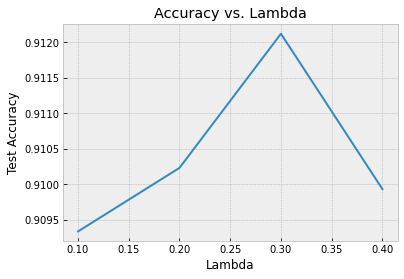

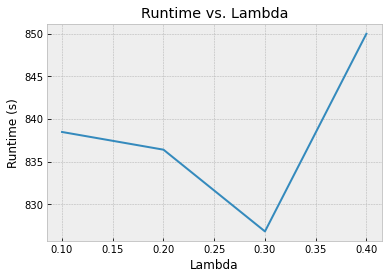

In [73]:
print(test_acc_all2)
print(run_times2)
plt.figure()
plt.title('Accuracy vs. Lambda')
plt.plot(lam, test_acc_all2, label='Batch=32')
# plt.plot(lam, test_acc_all2[1,:], label='Batch=64')
# plt.plot(lam, test_acc_all2[2,:], label='Batch=128')

plt.xlabel('Lambda')
plt.ylabel('Test Accuracy')
plt.savefig('AccVsLambda.png');

plt.figure()
plt.title('Runtime vs. Lambda')
plt.plot(lam, run_times2, label='Batch=32')
# plt.plot(lam, run_times2[1,:], label='Batch=64')
# plt.plot(lam, run_times2[2,:], label='Batch=128')

plt.xlabel('Lambda')
plt.ylabel('Runtime (s)');